In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import datetime
import numpy as np
import pickle as pkl
import statsmodels
import seaborn as sns
from tqdm.notebook import tqdm
from scipy import stats
import matplotlib.pyplot as plt
from multiprocessing import cpu_count
from graspy.simulations import p_from_latent, sample_edges
from graspy.inference import LatentDistributionTest
from sklearn.metrics.pairwise import pairwise_kernels

In [2]:
def make_a_graph(n, case=0, scale=0.3, loc=0.3):
    if case == 0:
        latent1 = stats.uniform.rvs(0, 1, size=n).reshape(-1, 1) * scale + loc
    elif case == 1: 
        latent1 = stats.beta.rvs(0.25, 0.25, size=n).reshape(-1, 1) * scale + loc
    elif case == 2:     
        latent1 = np.random.binomial(1, 0.5, n).reshape(-1, 1) * scale + loc
    p_mat1 = p_from_latent(latent1, rescale=False, loops=False)
    X_graph = sample_edges(p_mat1, directed=False, loops=False)
    return X_graph

In [3]:
def mc_iter(n, m, p, q, test_type, i=1):
    X_graph = make_a_graph(n, case=p)
    Y_graph = make_a_graph(m, case=q)    
    
    def metric_func(X, Y=None, workers=None):
        return pairwise_kernels(X, Y, metric="rbf", gamma=2)
    
    ldt = LatentDistributionTest(test="hsic",
                                 metric=metric_func,
                                 n_components=1,
                                 workers=cpu_count() - 2,
                                 size_correction=test_type)
    pval = ldt.fit_predict(X_graph, Y_graph)

    return pval

In [4]:
def monte_carlo(n, m, p, q, test_type=False, mc_iters=1000):
    '''
    n: size of the first graph
    m: size of the second graph
    p: latent position of the first graph
    q: latent poisiton of the second graph
    test_type: boolean, to set size_correction
    mc_iters: number of monte-carlo-iterations
    '''
    pvals = np.zeros(mc_iters)
    
    results = [None] * mc_iters
    for i in tqdm(range(mc_iters)):
        results[i] = mc_iter(n, m, p, q, test_type)

    return np.array(pvals)

In [5]:
n = 500
m = 5000
mc_iters = 1000

The following (commented out) cell runs the simulation from scratch if uncommented. Depending on your system it can take hours, or even days with the settings provided by default. To run a smaller simulation, decrease the number of monte carlo iterations used. If the following cell is not uncommented, the notebook will use data from our run to generate the figure.

In [6]:
# size_results = []
# for i in range(3):
#     size_results.append(monte_carlo(n, m, i, i, test_type=False, mc_iters=mc_iters))
#     size_results.append(monte_carlo(n, m, i, i, test_type=True, mc_iters=mc_iters))

# power_results = []
# for i in range(3):
#     for j in range(3):
#         a = monte_carlo(n, m, i, j, test_type=True, mc_iters=mc_iters)
#         print(i, j, np.mean(a < 0.05))
#         power_results.append(a)

# pkl.dump(size_results, open( "../data/graphs_rdpg_size_results.pkl", "wb" ) )
# pkl.dump(power_results, open( "../data/graphs_rdpg_power_results.pkl", "wb" ) )

In [7]:
size_results = pkl.load(open( "../data/graphs_rdpg_size_results.pkl", "rb" ) )
power_results = pkl.load(open( "../data/graphs_rdpg_power_results.pkl", "rb" ) )

In [8]:
def plot_size_sim(sim_p_vals_array):
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    for i in range(2):
        axis = ax[i]
        sim_p_vals = sim_p_vals_array[i]
        plt.style.use("seaborn-white")
        sns.set_palette("deep")
        sns.set_context("paper", font_scale=1.5)
        axis.plot(np.arange(len(sim_p_vals))/len(sim_p_vals),
                np.linspace(1/len(sim_p_vals),1,num=len(sim_p_vals)),
                 label='cdf of a uniform distribution', color='k', alpha=0.7)
        sns.distplot(sim_p_vals,
                     bins=np.linspace(0, 1, 20, endpoint=True),
                     hist_kws={'cumulative': True, 'label' : 'empirical cdf histogram'},
                     kde_kws={'cumulative': True, 'label': 'empirical cdf kde', 'bw' : 0.04},
                     ax=axis)
        axis.set_xlim([0, 1])
        if i == 0:
            axis.set_title("Nonparametric test using ASE")
        elif i == 1:
            axis.set_title("Nonparametric test using CASE")
        axis.set_xlabel("p-value")
        axis.set_ylabel("empirical cdf")
        axis.legend()
    return fig

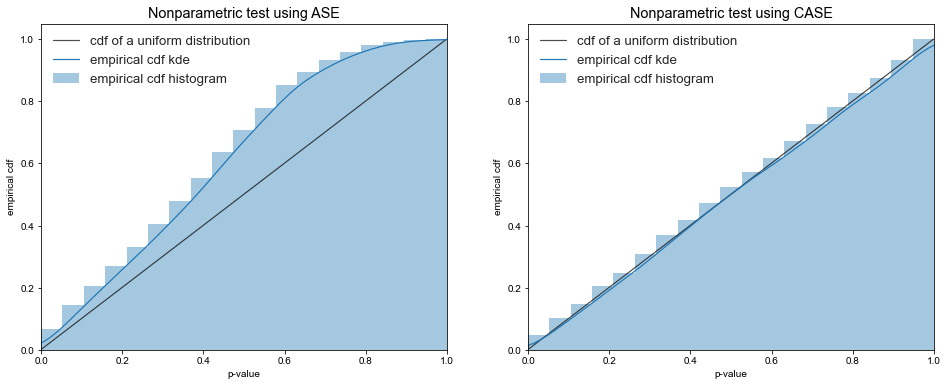

In [9]:
fig = plot_size_sim(size_results[:2]);
fig.savefig('../figures/graphs_rdpg_histograms.png',
           bbox_inches='tight',
           dpi=300)

In [10]:
size_uncorrected = np.mean(size_results[0] <= 0.05)
size_corrected = np.mean(size_results[1] <= 0.05)
size_uncorrected, size_corrected

(0.068, 0.049)

In [11]:
size_uncorrected_std = np.sqrt(size_uncorrected*(1-size_corrected)/mc_iters)
size_corrected_std = np.sqrt(size_corrected*(1-size_corrected)/mc_iters)


In [12]:
print(f"uncorrected CI: ({size_uncorrected - 1.96 *size_uncorrected_std, size_uncorrected_std + 1.96})")
print(f"corrected CI: ({size_corrected - 1.96 *size_corrected_std, size_corrected_std + 1.96})")

uncorrected CI: ((0.05223838241803844, 1.9680416416234496))
corrected CI: ((0.03562036179861354, 1.9668263460211155))


In [13]:
stats.norm.cdf(0.05, loc=size_uncorrected,
               scale=np.sqrt(size_uncorrected*(1-size_uncorrected)/mc_iters))

0.011878092404488191

In [14]:
(np.array(power_results).reshape(3,3,mc_iters) < 0.05).mean(axis=(2))

array([[0.049, 0.957, 1.   ],
       [0.996, 0.043, 0.514],
       [1.   , 0.807, 0.052]])